<h3 align="center">Task N1 - NN training with torch</h3>

- **Fully connected neural networks** are the foundation of deep learning models. Able to learn any function they are powerful estimators. While it's easy to build and train neural network, debugging it becomes harder and harder more complex the network becomes. Forward and backward pass might run but there could be some other mathematical error which keeps network from learning.

- To get the dataset use the code below:
```
import pandas as pd
col_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
data = pd.read_csv(url, header=None, names=col_names)
```

- Your task is to train a binary classification network with binary cross entropy loss for predicting diabetes. Train your network with torch and with pytorch-lightning, explain your findings, reason around the network's performance, try different hyperparameters/network architecture setups

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
import seaborn as sns
import sklearn
import warnings
import miceforest as mf
from joblib import dump, load

from sklearn.model_selection import train_test_split

import math
import copy
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from miceforest import ImputationKernel
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

## EDA

In [2]:
col_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
data = pd.read_csv(url, header=None, names=col_names)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
data['Insulin'][data['BloodPressure'] == 0].count()

35

c:\Users\opala\miniconda3\envs\ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\opala\miniconda3\envs\ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\opala\miniconda3\envs\ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\opala\miniconda3\envs\ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

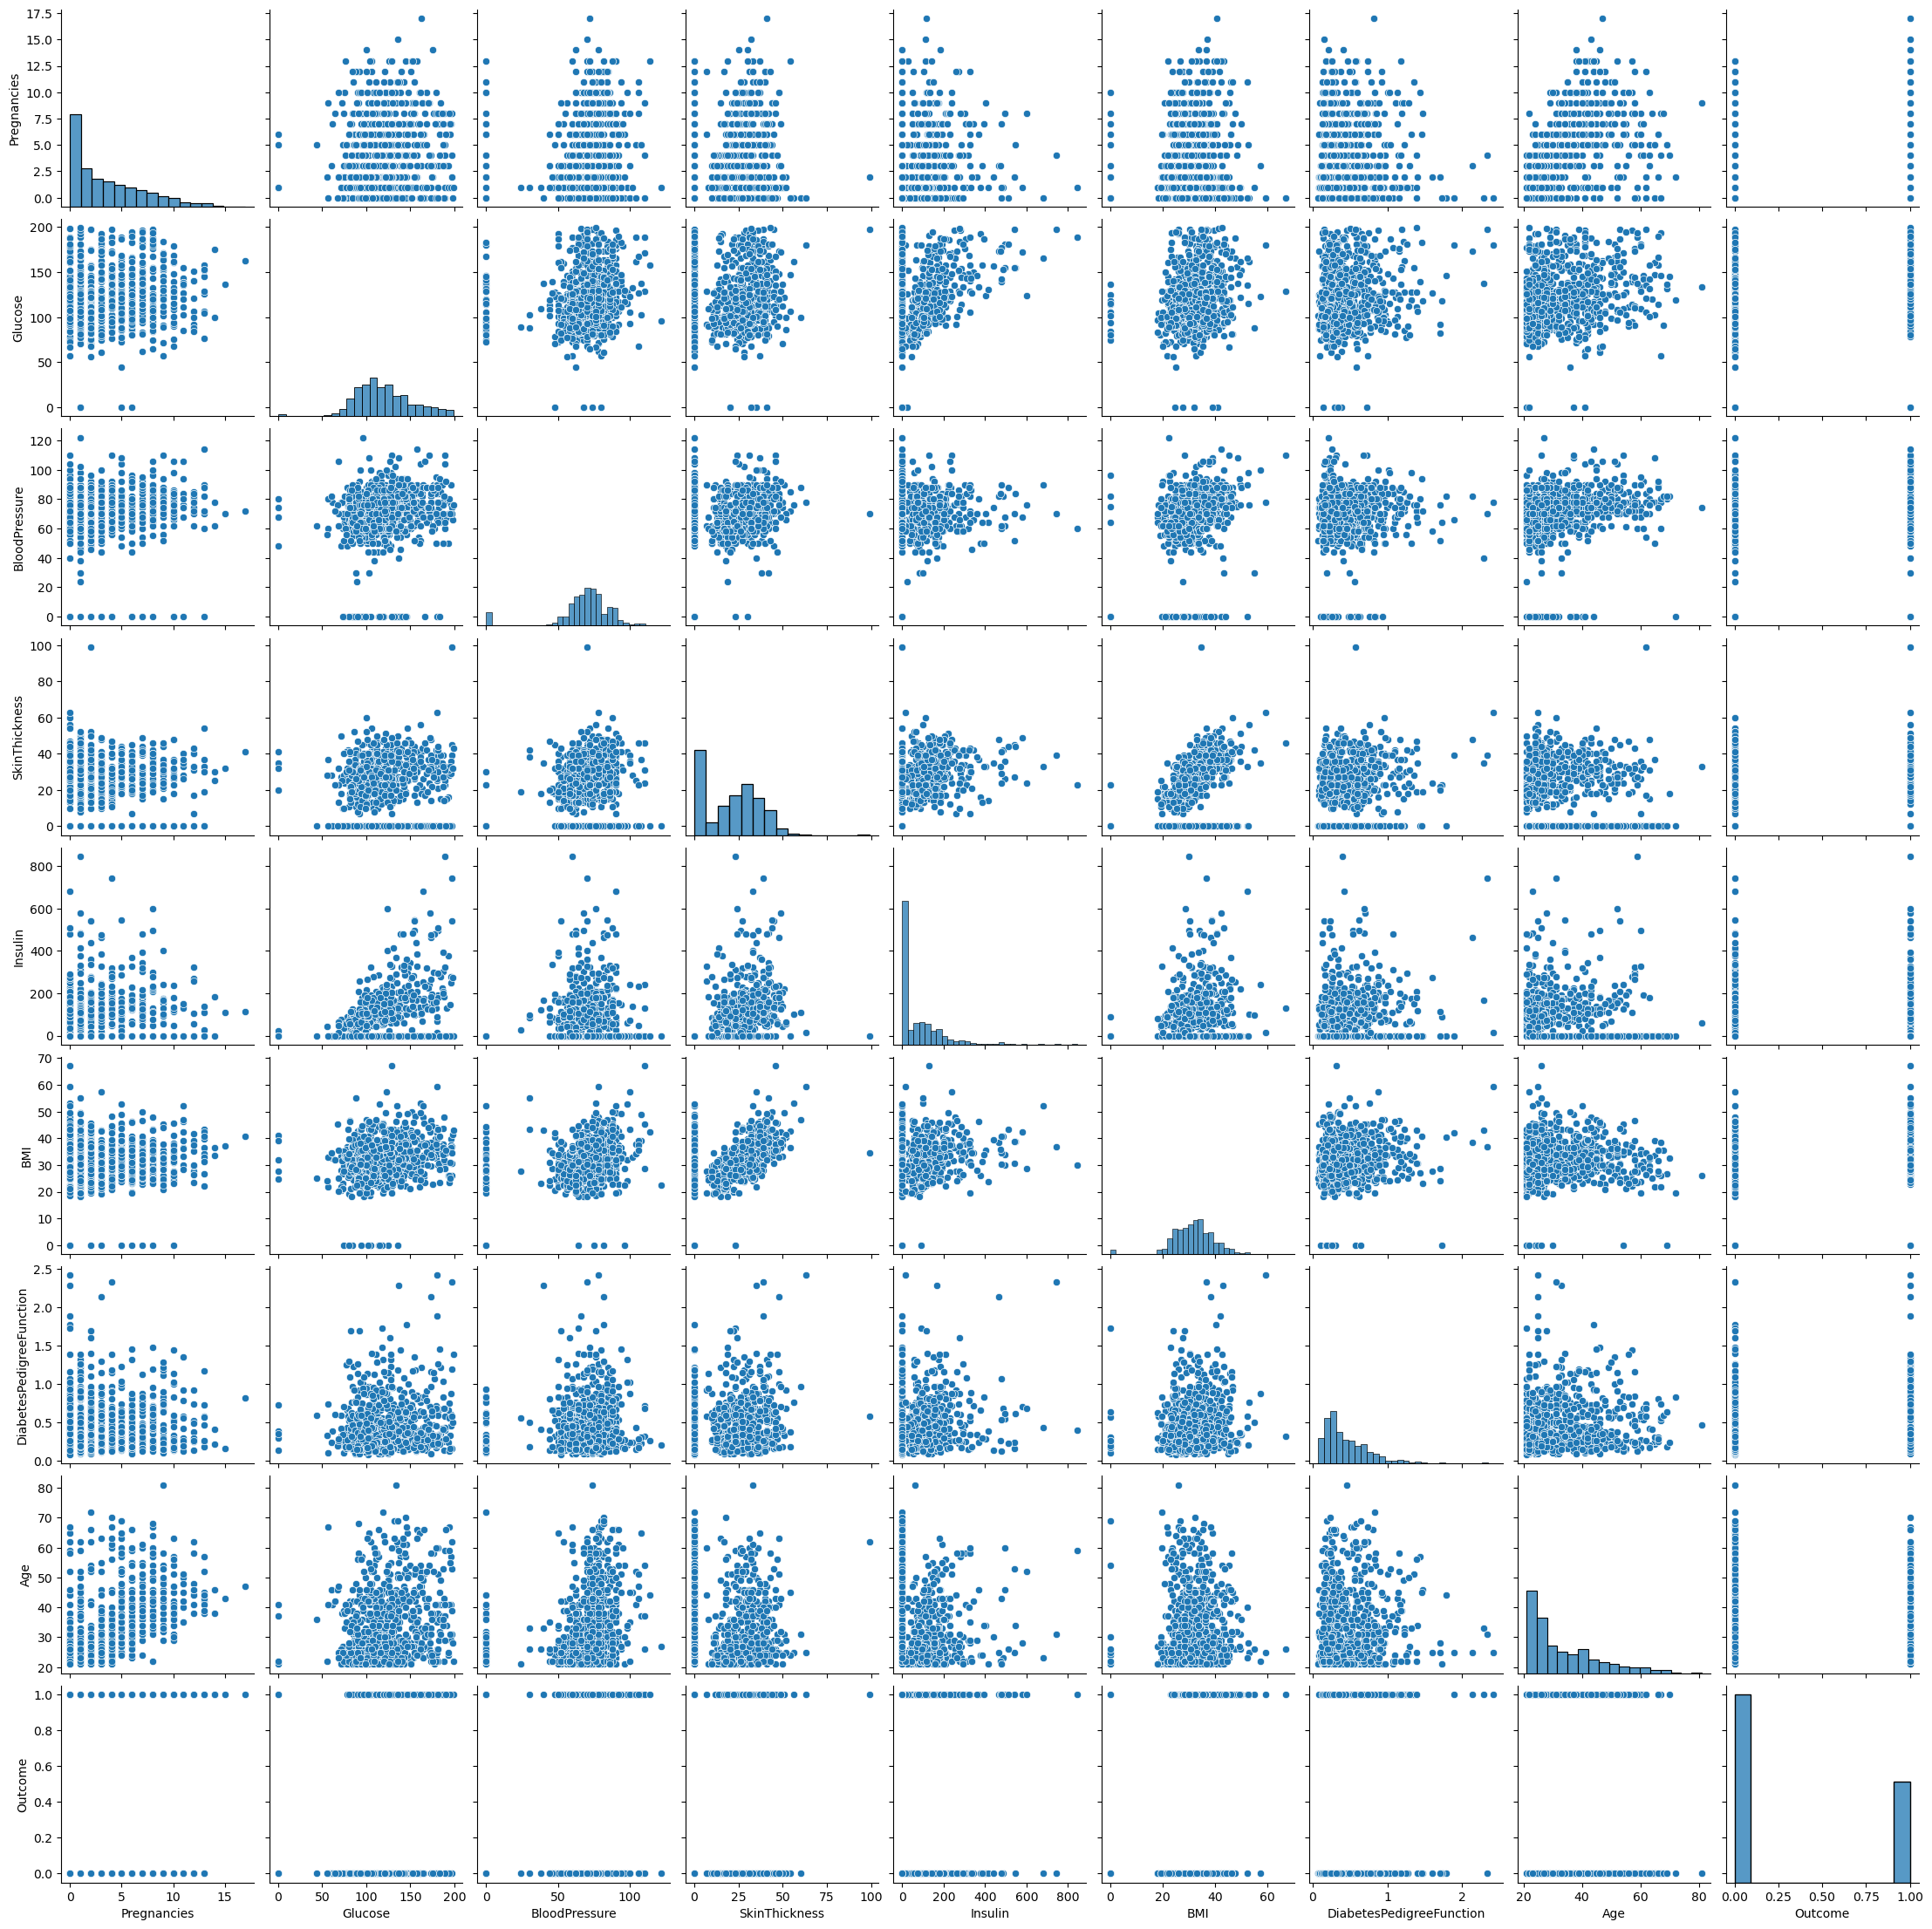

In [4]:
sns.pairplot(data)

We can see some 0 values in BloodPressure, SkinThickness,Insulin and BMI columns. Such values are not possible in real life - they probably mean that there is no value measured for given observation. We will impute new values in their place based on other columns and rows.

## DATA PREPARATION

In [5]:
columns_to_replace = ['BloodPressure', 'SkinThickness','Insulin', 'BMI']
data[columns_to_replace] = data[columns_to_replace].replace(0, np.nan)
data.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137,40.0,35.0,168.0,43.1,2.288,33,1


In [6]:
X, y = data.drop(columns=['Outcome']), data['Outcome']
X = mf.utils.ampute_data(X)

Below we impute missing numerical values using Multiple Imputation by Chained Equations (MICE) algorithm. It imputs values in one column based on the rest of columns and repeat this for every column and for a desired number of iterations (cycles) over all of columns.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True)

In [8]:
mice_kernel = mf.ImputationKernel(X_train, datasets=1)

pipe = Pipeline([
    ('impute', mice_kernel),
    ('std_scaler', StandardScaler())
    #('poly-features', PolynomialFeatures(degree=2))
])

X_train = pipe.fit_transform(X_train,impute__iterations=2)
X_test = pipe.transform(X_test)
# Show that neither now have missing values.
assert not np.any(np.isnan(X_train))
assert not np.any(np.isnan(X_test))

In [9]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1,1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1,1)

Lets create function for building models. We will introduce batch_normalization which works as regularizer but also helps with the vanishing gradients problem. We will also use initialization method he as default for the same purpose. After each layer we use ReLu activation function and in the end of course sigmoid for predicting probability of being in positive class.

In [10]:
def build_model(layer_sizes, batch_norm=True, initialization='he'):
    layers = []
    for i in range(len(layer_sizes) - 1):
        linear_layer = nn.Linear(layer_sizes[i], layer_sizes[i+1])
        
        if initialization == 'he':
            nn.init.kaiming_normal_(linear_layer.weight, mode='fan_in', nonlinearity='relu')
        elif initialization == 'xavier':
            nn.init.xavier_uniform_(linear_layer.weight)
        # Add the initialized linear layer to the model
        layers.append(linear_layer)
        
        if batch_norm:
            layers.append(nn.BatchNorm1d(layer_sizes[i+1]))
        layers.append(nn.ReLU())
    
    layers.append(nn.Sigmoid())
    model = nn.Sequential(*layers)
    return model

input_layer_size = X.shape[1] #8
#layer_sizes = [input_layer_size,64,32,16,8,1]

#model = build_model(layer_sizes)

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

Function for training model.

In [13]:
def train_model(model, X_train, X_test, y_train, y_test, n_epochs, batch_size, loss_fn, optimizer):

    best_loss = np.inf   
    best_weights = None
    history_val = []
    history_train = []

    for epoch in range(n_epochs):
        model.train()
        total_train_loss = 0.0
        # Ensure batch_start is correctly defined, e.g., range(0, len(X_train), batch_size)
        #for start in tqdm.tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch}", unit="batch"):
        for start in range(0, len(X_train), batch_size):

            end = min(start + batch_size, len(X_train))
            X_batch = X_train[start:end]
            y_batch = y_train[start:end]

            optimizer.zero_grad()

            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
    
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * (end - start + 1)


        average_train_loss = total_train_loss / len(X_train)
        model.eval()
        history_train.append(average_train_loss)

        y_pred = model(X_test)
        val_loss = loss_fn(y_pred, y_test)
        val_loss = float(val_loss)
        history_val.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_weights = copy.deepcopy(model.state_dict())

    # restore the best model
    model.load_state_dict(best_weights)

    return model, history_train, history_val, best_loss

Function for testing different parameters of models and training methods.

In [14]:
def test_models( X_train, X_test, y_train, y_test,architectures,lr,batch_size,n_epochs=50,plot=False):#lr=0.001,batch_size=32,n_epochs = 30):
    
    min_loss = float('inf')
    if plot:
        plt.figure(figsize=(10, 5))
    
    for i, architecture in enumerate(architectures):

        model = build_model(architecture)
        model = model.to(device)
        batch_start = torch.arange(0, len(X_train), batch_size)
        loss_fn = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        model, history_train, history_val, loss = train_model(model, X_train, X_test, y_train, y_test, n_epochs, batch_size, loss_fn, optimizer)

        print(f' Loss: {loss}, Learning rate: {lr}, Batch size: {batch_size}, Architecture:  {architecture}' )

        if loss < min_loss:
            best_model = model
            best_model_history_train = history_train
            best_model_history_val = history_val
            best_architecture = architecture
    
        if plot:
            plt.plot(history_val,linestyle='--', label=f'Val {i}')
            plt.plot(history_train, label=f"Train {i}")

    if plot: 
        plt.title('Learning Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Binary Cross Entropy')
        plt.legend()
        plt.grid(True)
        plt.show()

    #print(f'Best architecture:  {best_architecture}, Batch Size: {batch_size}, lr: {lr}')

    return best_model

We'll try some shallower and some deeper networks, with few batch sizes and learning rates.

In [15]:
architecture1 = [input_layer_size,64,32,16,8,1]
architecture2 = [input_layer_size,16,12,8,4,1]
architecture3 = [input_layer_size,128,64,16,8,1]
architecture4 = [input_layer_size,64,48,32,24,16,12,8,1]
architecture5 = [input_layer_size,128,12,1]
architecture6 = [input_layer_size,32,12,4,1]

architectures = [architecture1,architecture3,architecture4,architecture5,architecture6]

In [85]:
for batch in [16,32,64]:
    for lr in [1e-5,1e-4,1e-3]:
        model = test_models( X_train, X_test, y_train, y_test,architectures,batch_size=batch,lr=lr) 


 Loss: 0.7090438008308411, Learning rate: 1e-05, Batch size: 16, Architecture:  [8, 64, 32, 16, 8, 1]
 Loss: 0.7519380450248718, Learning rate: 1e-05, Batch size: 16, Architecture:  [8, 128, 64, 16, 8, 1]
 Loss: 0.7799196839332581, Learning rate: 1e-05, Batch size: 16, Architecture:  [8, 64, 48, 32, 24, 16, 12, 8, 1]
 Loss: 0.7702758312225342, Learning rate: 1e-05, Batch size: 16, Architecture:  [8, 128, 12, 1]
 Loss: 0.8045355081558228, Learning rate: 1e-05, Batch size: 16, Architecture:  [8, 32, 12, 4, 1]
 Loss: 0.7215856313705444, Learning rate: 0.0001, Batch size: 16, Architecture:  [8, 64, 32, 16, 8, 1]
 Loss: 0.7085573077201843, Learning rate: 0.0001, Batch size: 16, Architecture:  [8, 128, 64, 16, 8, 1]
 Loss: 0.7261391878128052, Learning rate: 0.0001, Batch size: 16, Architecture:  [8, 64, 48, 32, 24, 16, 12, 8, 1]
 Loss: 0.6707941889762878, Learning rate: 0.0001, Batch size: 16, Architecture:  [8, 128, 12, 1]
 Loss: 0.664406955242157, Learning rate: 0.0001, Batch size: 16, Arc

Lowest loss: 0.6598509550094604 was obtained for , Learning rate: 0.001, Batch size: 32, Architecture:  [8, 128, 64, 16, 8, 1]. Lets train this model and check accuracy it reaches.

In [88]:
model = build_model([8, 128, 64, 16, 8, 1])
model = model.to(device)
batch_start = torch.arange(0, len(X_train), batch_size)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model, history_train, history_val, loss = train_model(model, X_train, X_test, y_train, y_test, 50, 32, loss_fn, optimizer)

model.eval()

with torch.no_grad():
    y_pred = model(X_test)

y_pred_labels = (y_pred > 0.5).float()

correct = (y_pred_labels == y_test).sum().item()
total = len(y_test)
accuracy = correct / total

print(f'Models accuracy on test set: {accuracy}')

Models accuracy on test set: 0.6883116883116883


We could probably do much better with better selected architecture and more optimal parameters. However we could clearly see that this model outperformed others with much bigger layers and with more layers. It was probably related to overfitting - it could be prevented with some additional regularization or early stopping.

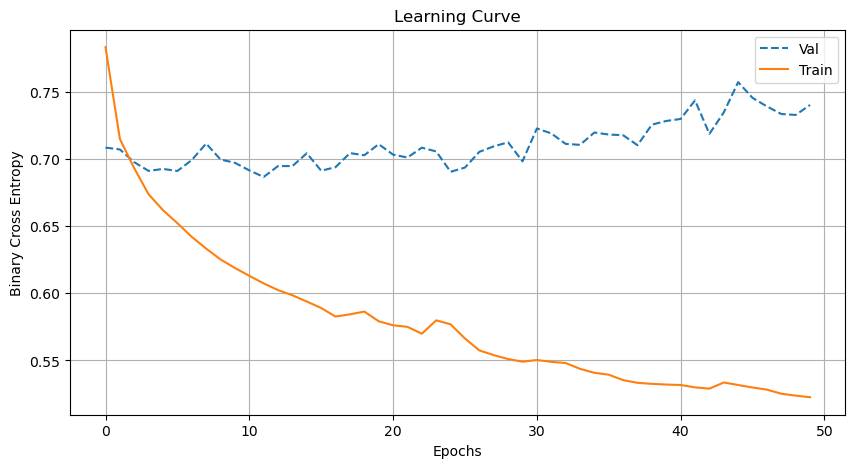

In [89]:
plt.figure(figsize=(10, 5))
plt.plot(history_val,linestyle='--', label=f'Val')
plt.plot(history_train, label=f"Train")

plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.legend()
plt.grid(True)
plt.show()

We can see that this model unfortunately quickly started overfitting. Training loss kept decreasing while validation error after just few epochs started to systematically grow. It is not a good sign.

In [16]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split

Lets create class using Lightning Module which will be used for training models, using Trainer feature.

In [17]:
class SimpleNN(pl.LightningModule):
    def __init__(self, layer_sizes, lr=0.001):
        super().__init__()

        layers = []
        for i in range(len(layer_sizes) - 1):
            linear_layer = nn.Linear(layer_sizes[i], layer_sizes[i+1])
            
            # Perform weight initialization (you can modify this part as needed)
            nn.init.kaiming_normal_(linear_layer.weight, mode='fan_in', nonlinearity='relu')
            
            layers.append(linear_layer)
            layers.append(nn.BatchNorm1d(layer_sizes[i+1]))
            layers.append(nn.ReLU())
        
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = nn.BCELoss()(y_pred, y.view(-1, 1).float())  # Binary Cross Entropy Loss
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        val_loss = nn.BCELoss()(y_pred, y.view(-1, 1).float())  # Validation loss calculation
        self.log('val_loss', val_loss)  # Logging the validation loss
        return val_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_test, y_test)

In [18]:
from pytorch_lightning.loggers import TensorBoardLogger

# Create a TensorBoard logger
tb_logger = TensorBoardLogger("logs/", name="my_model")

Now similar to what weve done before, well test some architectures, learning_rates, batch_sizes and extract the best combination of them for training the model.

In [20]:
def train_models(architectures, learning_rates, batch_sizes, X_train, X_test, y_train, y_test, n_epochs=15):
    best_models = {}
    best_loss = float('inf')
    best_architecture = None
    best_lr = None
    best_batch_size = None

    for architecture in architectures:
        for lr in learning_rates:
            for batch_size in batch_sizes:
                print(f"Training model with Architecture: {architecture}, LR={lr}, Batch Size={batch_size}")

                model = SimpleNN(architecture, lr=lr)
                model = model.to(device)

                train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
                val_dataset = torch.utils.data.TensorDataset(X_test, y_test)

                train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

                optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                criterion = nn.BCELoss()

                trainer = pl.Trainer(max_epochs=n_epochs, logger=tb_logger , log_every_n_steps=100)
                trainer.fit(model, train_loader, val_loader)


                val_loss = trainer.callback_metrics['val_loss']
                print(f'Validation Loss: {val_loss}')

                if val_loss < best_loss:
                    best_loss = val_loss
                    best_model = model
                    best_architecture = architecture
                    best_lr = lr
                    best_batch_size = batch_size

    print('Best Model Architecture:', best_architecture)
    print('Best Validation Loss:', best_loss)
    print('Best Learning Rate:', best_lr)
    print('Best Batch Size:', best_batch_size)

    return best_model

In [ ]:
lightning_model = train_models(architectures, [1e-5,1e-4,1e-3], [16,32,64], X_train, X_test, y_train, y_test, n_epochs=15)

In [22]:
lightning_model.eval()

with torch.no_grad():
    y_pred = lightning_model(X_test)

y_pred_labels = (y_pred > 0.5).float()

correct = (y_pred_labels == y_test).sum().item()
total = len(y_test)
accuracy = correct / total

print(f'Models accuracy on test set: {accuracy}')

Models accuracy on test set: 0.7012987012987013


Model obtained with lightning trainer managed to reach better generalization.

<h3 align="center">Task N2.1 - 1D Convolution operation</h3>

- **Convolution** is an operation when we have 2 functions and by merging them together we get a third function. For images, first "function" is the pixel values of the image and the second "function" is the filter itself. For 1D data(Like time-series or text) we have 1D Convolution kernels, for 2D/3D data we have appropriate kernels as well

- For time series data we can see on the below image how convolution operation is done on 1D data. It is often used for denoising the data. For example you can use an averaging kernel( 1/n, 1/n ... 1/n ) for denoising. Explain what tradeoff is between using large kernels and smaller kernels by observing the outputs.

![Image alt text](https://i.stack.imgur.com/WNIXd.png)

- Your task is to build a sliding window 1D convolution on a sine function with some noise added to it. Below you can see the code for initializing it and plotting the noisy data. Your task is to denoise the `noisy_signal` variable. Write a function which will take in the `noisy_signal` and denoise it with 1D convolution.
```
N = 1000  # Number of data points
t = np.linspace(0, 4*np.pi, N)  # Time variable
clean_signal = np.sin(t)  # Clean sin function
noise = np.random.normal(0, 0.5, N)
noisy_signal = clean_signal + noise
plt.plot(t, noisy_signal)
plt.title('Noisy Signal')
plt.show()
```

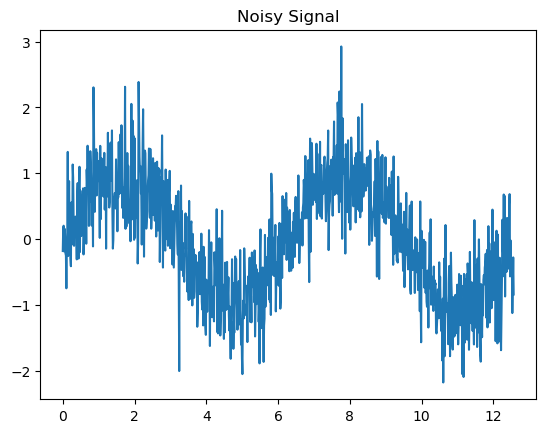

In [2]:
N = 1000  # Number of data points
t = np.linspace(0, 4*np.pi, N)  # Time variable
clean_signal = np.sin(t)  # Clean sin function
noise = np.random.normal(0, 0.5, N)
noisy_signal = clean_signal + noise
plt.plot(t, noisy_signal)
plt.title('Noisy Signal')
plt.show()

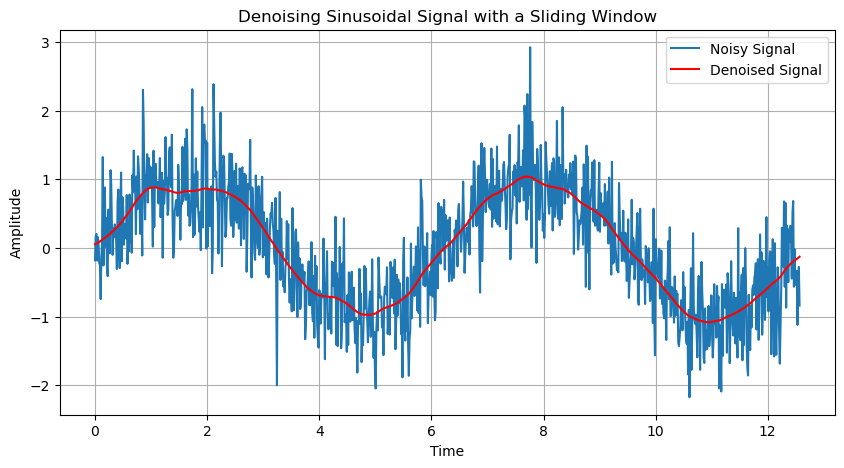

In [3]:
'''
def sliding_window_average(signal, window_size):
    smoothed_signal = np.zeros(len(signal))
    for i in range(len(signal) - window_size + 1):
        window = signal[i:i+window_size]
        smoothed_signal[i+window_size//2] = np.mean(window)
    return smoothed_signal
'''

def conv1d(signal, kernel):

    kernel_size = len(kernel)
    smoothed_signal = np.zeros(len(signal))

    for i in range(len(signal)):

        #here no padding is effectively zero-padding
        left = max(0,i-kernel_size//2)
        right = min(len(signal)-1,i+kernel_size//2)
        window = signal[left:right]

        smoothed_signal[i] = np.dot(window, kernel[kernel_size//2 + 1 - (i - left):kernel_size//2 + 1 + (right - i)])

    return smoothed_signal

#window_size = 100  # Adjust the window size as needed
#smoothed_signal = sliding_window_average(noisy_signal, window_size)

#kernel = [0.1,0.2,0.4,0.2,0.1]
#kernel = [0.04,0.06,0.10,0.15,0.3,0.15,0.10,0.06,0.04]
increasing = np.linspace(0, 0.5, num=(75 // 2) + 1)
decreasing = np.linspace(0.5, 0, num=(75 // 2) + 1)[1:]
kernel = np.concatenate((increasing, decreasing))
kernel /= np.sum(kernel)
smoothed_signal = conv1d(noisy_signal, kernel)

# Plot the noisy signal and the denoised signal
plt.figure(figsize=(10, 5))
plt.plot(t, noisy_signal, label='Noisy Signal')
plt.plot(t, smoothed_signal, label='Denoised Signal', color='red')
plt.legend()
plt.title('Denoising Sinusoidal Signal with a Sliding Window')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

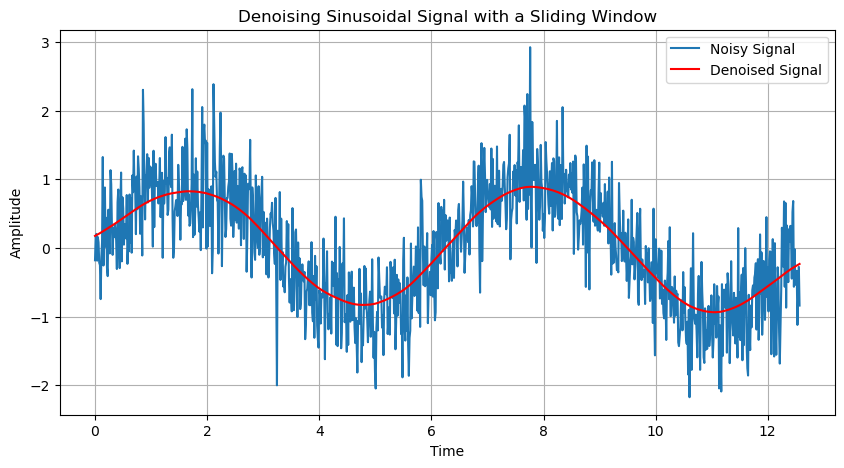

In [83]:
increasing = np.linspace(0, 0.5, num=(201 // 2) + 1)
decreasing = np.linspace(0.5, 0, num=(201 // 2) + 1)[1:]
kernel = np.concatenate((increasing, decreasing))
kernel /= np.sum(kernel)
smoothed_signal = conv1d(noisy_signal, kernel)

# Plot the noisy signal and the denoised signal
plt.figure(figsize=(10, 5))
plt.plot(t, noisy_signal, label='Noisy Signal')
plt.plot(t, smoothed_signal, label='Denoised Signal', color='red')
plt.legend()
plt.title('Denoising Sinusoidal Signal with a Sliding Window')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

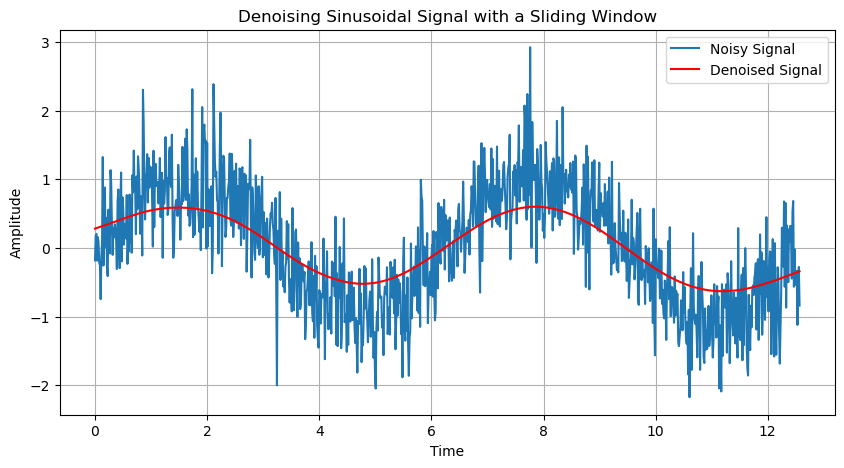

In [84]:
increasing = np.linspace(0, 0.5, num=(401 // 2) + 1)
decreasing = np.linspace(0.5, 0, num=(401 // 2) + 1)[1:]
kernel = np.concatenate((increasing, decreasing))
kernel /= np.sum(kernel)
smoothed_signal = conv1d(noisy_signal, kernel)

# Plot the noisy signal and the denoised signal
plt.figure(figsize=(10, 5))
plt.plot(t, noisy_signal, label='Noisy Signal')
plt.plot(t, smoothed_signal, label='Denoised Signal', color='red')
plt.legend()
plt.title('Denoising Sinusoidal Signal with a Sliding Window')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

We can see that for relatively small kernel size we are not able to completely smoothen our signal. However if we use too big kernel - we might flatten our signal - because it becomes just weighted average of almost all signal. When we increase size of the kernel too much we see that our curve smoothens but it barely reaches amplitude 0.5 while it should be reaching 1.


<h3 align="center">Task N2.2 - 2D Convolution operation</h3>

- In image processing **Convolution** filter/kernel is a $k \times k$ matrix which is used for retrieving useful features from the image. It is a fundamental building block of Convolutional neural networks(CNN)

- After applying the kernel over the image, we often get a downsampled feature map from the image as shown in the animation below:
  
<center><img src="https://drive.google.com/uc?export=view&id=153Aj-MSmLndc3dNhl9HvbpNZhDGlYB_I" alt="Example" /></center>


- Your job is to write a convolution operation as a function(without using packages like torch,tensorflow, keras etc.) which takes in image of shape (**CxHxW**, C - Channel(usually RGB), H - Height of the image, W - Width of the image) and get the output image after applying convolution like it's shown in the illustration. Keep dimensions of the image in mind, if kernel is larger than the image, 28x28 image let's say and user inputs kernel size of 30x30, then return an error. Implementing padding in this task is not needed.

- For testing the output you can use the **uniform blur** kernel for any image you like which is defined below:
  $$\begin{equation}K = \frac{1}{9} \begin{bmatrix} 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{bmatrix}\end{equation}$$

- Try your function on grayscale images with Sobel Operator and explain the output:
$$\begin{equation} K = \begin{bmatrix} -1 & 0 &  1 \\ -2 & 0 & 2 \\ -1 & 0 & 1  \end{bmatrix} \end{equation}$$

In [15]:
def conv2d(matrix, kernel, stride=(1,1), padding=(0,0)):

    matrix = np.array(matrix)

    if matrix.ndim == 2:
        matrix = matrix[:, :, np.newaxis]

    padd = ((padding[0], padding[0]), (padding[1], padding[1]),(0,0))
    matrix = np.pad(matrix, padd, mode='constant', constant_values=0)

    kernel = np.array(kernel)
    kernel_height = kernel.shape[0]
    kernel_width = kernel.shape[1]

    input_height = matrix.shape[0]
    input_width = matrix.shape[1]
    if len(matrix.shape) == 3:
        input_thick = matrix.shape[2]
    else:
        input_thick = 1

    output_height = (input_height - kernel_height) // stride[0] + 1
    output_width = (input_width - kernel_width) // stride[1] + 1

    output_matrix = np.zeros(shape=(output_height, output_width, input_thick))

    for channel in range(input_thick):
        for i in range(0, input_height - kernel_height + 1, stride[0]):
            for j in range(0, input_width - kernel_width + 1, stride[1]):
            
                window = matrix[i:i + kernel_height, j:j + kernel_width, channel]

                output_matrix[i // stride[0], j // stride[1], channel] = np.sum(window * kernel)

    if input_thick == 1:
        output_matrix = output_matrix[:, :, 0]

    return output_matrix

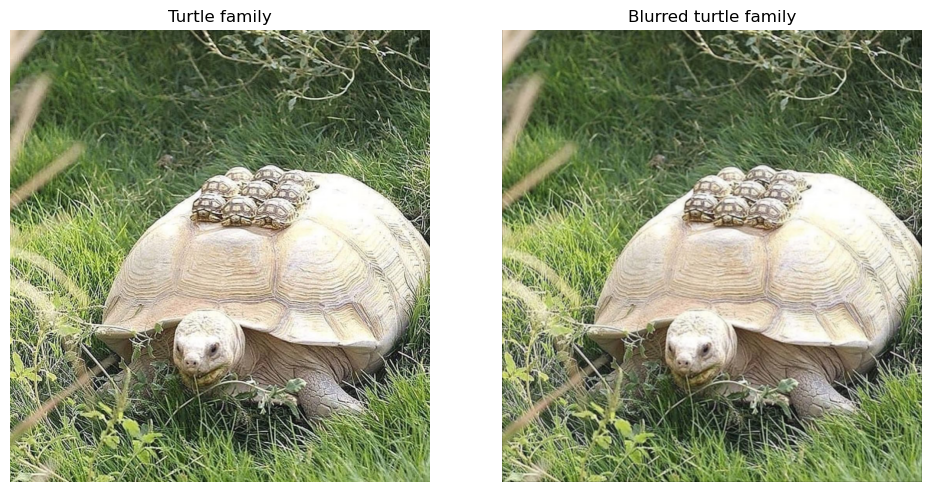

In [16]:
from PIL import Image

image = Image.open('fracturtle.jpg')
image = image.convert('RGB')
rgb_matrix = np.array(image)

blur_kernel = (1/9) * np.array([[1,1,1],[1,1,1],[1,1,1]])
blurred_rgb_matrix = conv2d(rgb_matrix,blur_kernel,padding=(1,1))
blurred_image = Image.fromarray(np.uint8(blurred_rgb_matrix))


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image
axes[0].imshow(image)
axes[0].axis('off')
axes[0].set_title('Turtle family')

# Display the second image
axes[1].imshow(blurred_image)
axes[1].axis('off')
axes[1].set_title('Blurred turtle family')

plt.tight_layout()
plt.show()

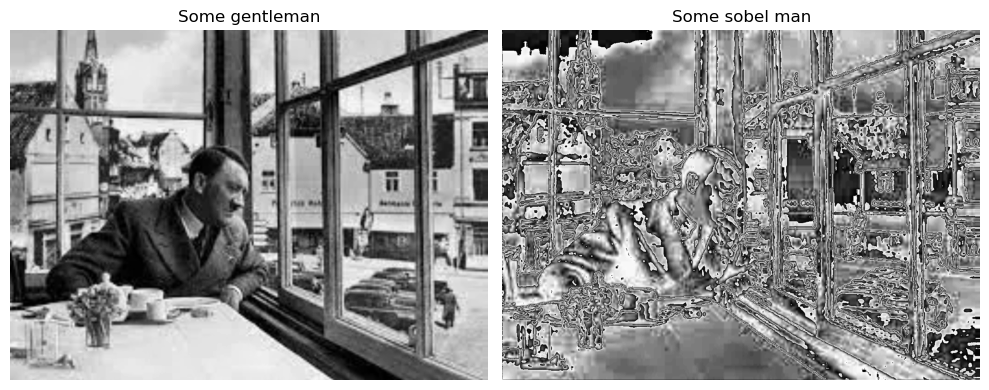

In [20]:
image2 = Image.open('entschuldigung.jpg')
image2 = image2.convert('L')
grayscale_matrix = np.array(image2)

sobel_kernel = np.array([[-1,0,-1],[-2,0,2],[-1,0,-1]])
sobel_grayscale_matrix = conv2d(grayscale_matrix,sobel_kernel,padding=(1,1))
sobel_image = Image.fromarray(np.uint8(sobel_grayscale_matrix), mode='L')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image
axes[0].imshow(image2, cmap = plt.cm.gray)
axes[0].axis('off')
axes[0].set_title('Some gentleman')

# Display the second image
axes[1].imshow(sobel_image, cmap = plt.cm.gray)
axes[1].axis('off')
axes[1].set_title('Some sobel man')

plt.tight_layout()
plt.show()

Uniform blur is a simple tool allowing us to decrease number of details in picture and the variance in it. Sobel kernel gives negative of a photo - it might for example help recognise some hidden features.